__Author:__ Kevin Fan
<br>__Last edited:__ 27/3/2025 MNE
<br>__Modified from code by:__ Lucie Luecke

This notebook reads the DoD2k, filters for late 20th century speleothem \delta^{18}O records, and uses CRUTS4.07 gridded temperature and precipitated weighted o18 of precipitation estimated by Bowen and Ravenaugh (2003, updated) to simulate o18 of speleothem calcite and compare results across a spatial gradient, to observations.  
# MNE: updated the comments here for the specific notebook

# Setup

In [1]:
## KF: Import appropriate libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.gridspec import GridSpec as GS
import scipy.io as sio
from copy import deepcopy as dc
import functions as f
import affine
import rasterio as rs #previous version was 1.3.5
import rasterio.features
from rasterio import transform
import pyproj
from matplotlib import pyplot
from rasterio.plot import show
from psm import speleo
import netCDF4
import cfr
import sklearn 
import math
from scipy import stats

In [2]:
# KF: Set up working directory. 
# The default working directory should be the parent folder to the database and helper files so we can access them 

# KF: Set the working directory and change into it- ensure this is correct!
wdir = "/home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree"
os.chdir(wdir)

# KF: Display the working directory
print('working directory: '+wdir)

# set the modeling data directory as well:
ddir = "/home/jupyter-lluecke/compile_proxy_database_v2.1/speleothem_modeling_inputs"
print('data inputs directory: '+ddir)

working directory: /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree
data inputs directory: /home/jupyter-lluecke/compile_proxy_database_v2.1/speleothem_modeling_inputs


# Reading and filtering data

In [3]:
# KF: Read data from database of databases pickle file

# MNE: revise to load current version: /home/jupyter-lluecke/compile_proxy_database_v2.1/dod2k_dupfree_dupfree/dod2k_dupfree_dupfree_compact.pkl
read_df    = pd.read_pickle('dod2k_dupfree_dupfree_compact.pkl') 
# Converts to dataframe
df_compact = pd.DataFrame(read_df)
# Displays dataframe
#df_compact.head()

In [4]:
# KF: Filter for desired data
# In this case, speleothem isotope measurements from the years 1800 - 2000 not from ch2k

#Speleothem filter # MNE adds: for just d18O
filtered_df = df_compact.loc[(df_compact["paleoData_proxy"] =="d18O") & (df_compact["archiveType"] == "speleothem") & (df_compact["originalDatabase"] != "CH2k v1.0.0")]
# archiveType filters for speleothem data
# originalDatasetName filters for CH2k data

# Filter data for time series that include records from or past the year 1960 AD
min_year = 1960 # Inclusive
max_year = 2006 # Exclusive

# Water isotopologue data ranges from 1960 to 2005- pick data to match the same timeframe
filtered_df = filtered_df.loc[df_compact["year"].apply(lambda x: np.max(x) >= min_year and np.min(x) < max_year)] #exclude data post to 2005
filtered_df.reset_index(inplace = True)

# Filter the filtered records for data in the correct timeframe
new_year = []
new_values = []
# For every row, apply above time conoditions
for i in range (0, len(filtered_df)):
    index = np.where(filtered_df.iloc[i]["year"] >= min_year)
    new_year.append(filtered_df.iloc[i]["year"][index]) # Adds values to lists
    new_values.append(filtered_df.iloc[i]["paleoData_values"][index])
filtered_df["year"] = new_year # Create a dataframe with the filtered data lists populating it
filtered_df["paleoData_values"] = new_values
filtered_df



,index,climateInterpretation_variable,climateInterpretation_variableDetail,dataSetName,datasetId,duplicateDetails,geo_meanElev,geo_meanLat,geo_meanLon,geo_siteName,originalDataURL,originalDatabase,paleoData_notes,paleoData_proxy,paleoData_sensorSpecies,paleoData_units,paleoData_values,year,yearUnits,archiveType
0,3266,moisture,precipitation amount,SP03BMIL,iso2k_SP03BMIL01A,N/A,400.0,32.580002,35.029999,"Soreq Cave, Israel",https://www.ncdc.noaa.gov/paleo/study/5423,Iso2k v1.0.1,; archiveType changed - was originally Speleot...,d18O,NULL,permil,[-5.25],[2000.0],CE,speleothem
1,3267,N/A,the position between the ecotone of desiduous ...,SP04DEUS,iso2k_SP04DEUS01A,N/A,332.0,44.833302,-92.250000,"Crystal Cave, Wisconsin",https://www.ncdc.noaa.gov/paleo/study/5428,Iso2k v1.0.1,; archiveType changed - was originally Speleot...,d18O,NULL,permil,"[-6.58207, -6.58207, -6.72757]","[1995.0, 1995.0, 1977.0]",CE,speleothem
2,3272,moisture,P,SP06DYCN,iso2k_SP06DYCN01A,Duplicate record details: sisal_446.0_292 in S...,680.0,25.280001,108.080002,"Dongge Cave, China",https://www.ncdc.noaa.gov/paleo-search/study/5441,Iso2k v1.0.1,; archiveType changed - was originally Speleot...,d18O,NULL,permil,[-7.9],[1966.5],CE,speleothem
3,3273,moisture,P,SP07ASUS,iso2k_SP07ASUS01A,Duplicate record details: sisal_613.0_379 in S...,1244.0,32.083000,-105.166702,"pink Panter Cave, New Mexico",https://www.ncdc.noaa.gov/paleo/study/9739,Iso2k v1.0.1,; archiveType changed - was originally Speleot...,d18O,NULL,permil,[-4.14],[1965.0],CE,speleothem
4,3278,moisture,P,SP08HUCN,iso2k_SP08HUCN01A,Duplicate record details: sisal_253.0_171 in S...,294.0,30.450001,110.416000,"Heshang Cave, China",https://www.ncdc.noaa.gov/paleo/study/6095,Iso2k v1.0.1,; archiveType changed - was originally Speleot...,d18O,NULL,permil,"[-7.96, -7.95, -7.86, -7.92, -8.11, -7.95, -7....","[2002.0, 2001.0, 2000.0, 1999.0, 1998.0, 1997....",CE,speleothem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,4480,temperature+moisture,temperature+moisture - manually assigned by Do...,Bunker cave,sisal_886.0_524,N/A,184.0,51.367500,7.664700,Bunker cave,10.1016/j.gloplacha.2020.103266,SISAL v3,calcite,d18O,N/A,permil,"[-5.2739596, -5.08625, -5.197091, -5.3154073, ...","[2003.9828, 2001.4604, 1998.9331, 1996.4008, 1...",CE,speleothem
103,4483,temperature+moisture,temperature+moisture - manually assigned by Do...,Kocain cave,sisal_887.0_527,N/A,730.0,37.232498,30.711700,Kocain cave,10.1029/2021GL094733,SISAL v3,calcite,d18O,N/A,permil,"[-3.77, -3.73, -3.64, -3.67, -3.67, -3.71, -3....","[2000.22, 1995.22, 1990.24, 1985.27, 1980.31, ...",CE,speleothem
104,4500,temperature+moisture,temperature+moisture - manually assigned by Do...,Sahiya cave,sisal_900.0_540,N/A,1190.0,30.600000,77.866699,Sahiya cave,10.1038/ncomms7309,SISAL v3,calcite,d18O,N/A,permil,"[-8.5104265, -8.46978, -8.51153, -8.662677, -8...","[2006.3071, 2005.6053, 2004.8984, 2003.4688, 2...",CE,speleothem
105,4510,temperature+moisture,temperature+moisture - manually assigned by Do...,Okshola cave,sisal_95.0_52,N/A,165.0,67.000000,15.000000,Okshola cave,10.5194/cp-5-667-2009,SISAL v3,calcite,d18O,N/A,permil,[-7.062788],[1997.0],CE,speleothem


In [5]:
#%% print some info about the data
proxy_types   = filtered_df['paleoData_proxy'].unique()
archive_types = filtered_df['archiveType'].unique()

counts      = []
for pt in proxy_types:
    cc = filtered_df['paleoData_proxy'][filtered_df['paleoData_proxy']==pt].count()
    # print('%25s'%pt+': '+str(cc))
    counts += [cc]

print(proxy_types)
print(archive_types)

['d18O']
['speleothem']


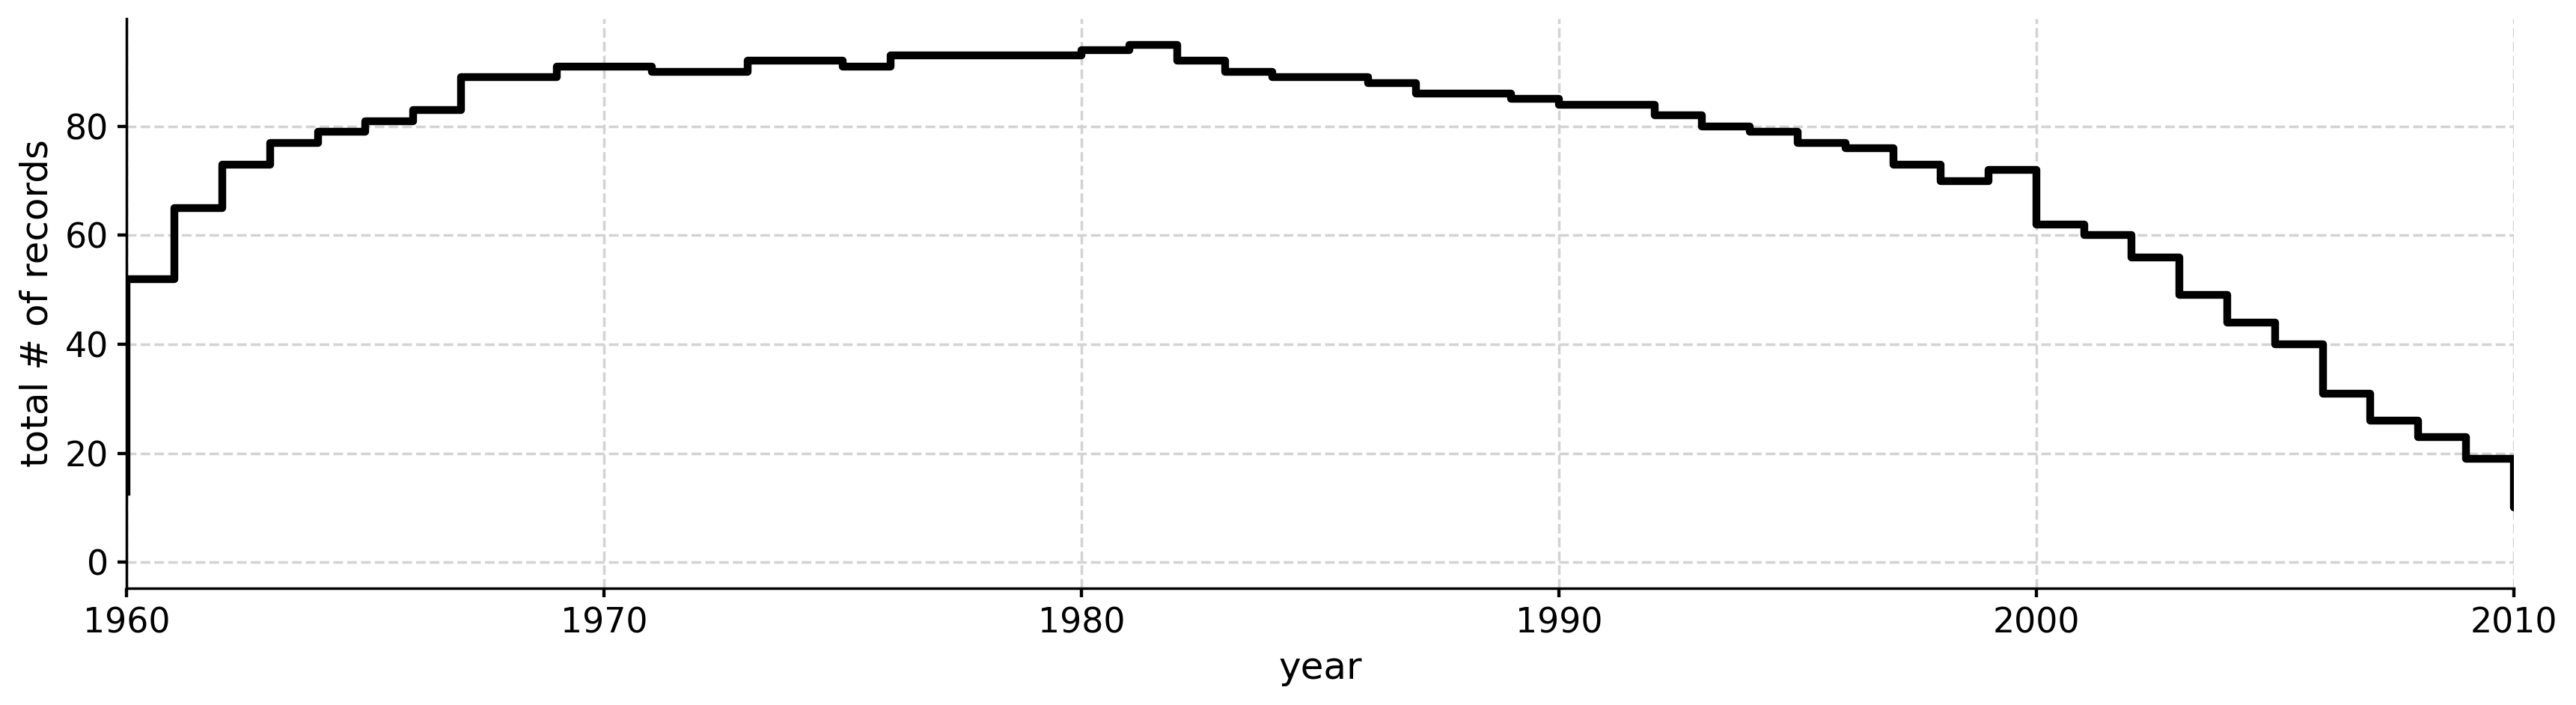

In [6]:

#%% plot the temporal coverage 
MinY     = [min([float(sy) for sy in yy])  for yy in filtered_df['year']] # find minimum year for each record
MaxY     = [max([float(sy) for sy in yy])  for yy in filtered_df['year']] # find maximum year for each record
MinMaxY  = np.array([MinY, MaxY]).T
years    = np.arange(min(MinY), max(MaxY)+1)

# generate array of coverage (how many records are available each year, in total)
coverage = np.zeros(years.shape[0])
for ii in range(len(filtered_df['year'])):
    coverage[(years>=MinY[ii])&(years<=MaxY[ii])] += 1

# plot results
fig = plt.figure(figsize=(14, 4), dpi=250)
ax = plt.gca()
plt.step(years, coverage, color='k', label='all records', lw=3)
plt.xlabel('year')
plt.ylabel('total # of records')

plt.xlim(min_year, max_year+4) # 1960 - 2010 range
ax.grid(True)
fig.tight_layout()

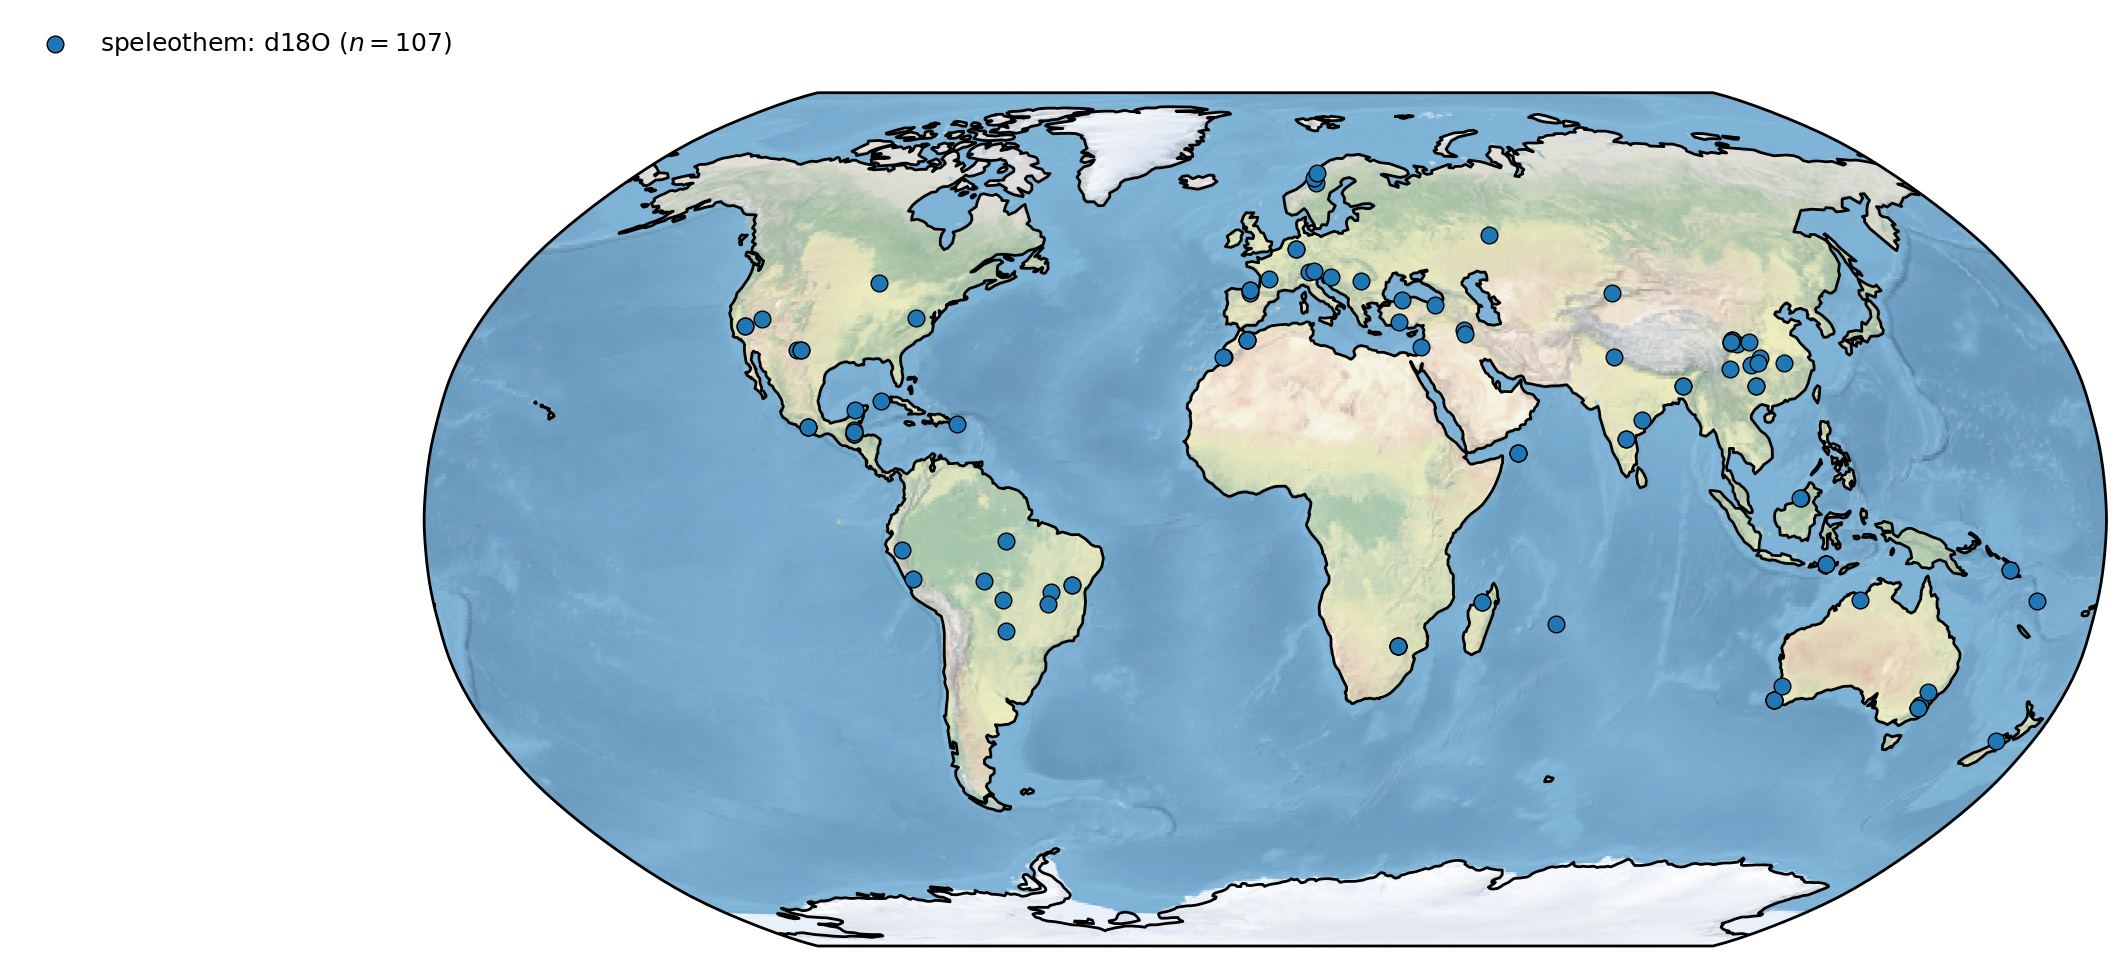

In [7]:
#%% plot the spatial distribution of all records
proxy_lats = filtered_df['geo_meanLat'].values
proxy_lons = filtered_df['geo_meanLon'].values

# plots the map
fig = plt.figure(figsize=(15, 5), dpi=200)
grid = GS(1, 3)


ax = plt.subplot(grid[:, -2:], projection=ccrs.Robinson()) # create axis with Robinson projection of globe
ax.stock_img()
ax.add_feature(cfeature.LAND) # adds land features
ax.coastlines() # adds coastline features

mt = 'ov^<>pP*XDd'*10 # generates string of marker types
archive_marker = {aa: mm for aa, mm in zip(archive_types, mt)} # attributes marker type to each archive type

# loop through the data to generate a scatter plot of each data record:
# 1st loop: go through archive types individually (determines marker type)
# 2nd loop: through paleo proxy types attributed to the specific archive, which is colour coded
for jj, arch in enumerate(archive_types):
    arch_mask = filtered_df['archiveType']==arch
    arch_proxy_types = np.unique(filtered_df['paleoData_proxy'][arch_mask])
    cc = f.get_colours(range(len(arch_proxy_types)), 'tab10', 0, len(arch_proxy_types))
    for ii, pt in enumerate(arch_proxy_types):
        pt_mask = filtered_df['paleoData_proxy']==pt
        plt.scatter(proxy_lons[pt_mask], proxy_lats[pt_mask], 
                    transform=ccrs.PlateCarree(), zorder=999,
                    marker=archive_marker[arch], color=cc[ii], 
                    label=arch+': '+pt+' ($n=%d$)'%filtered_df['paleoData_proxy'][pt_mask].count(), 
                    lw=.5, ec='k')
plt.legend(bbox_to_anchor=(0.03,1.1), ncol=2, fontsize=9, framealpha=0)
grid.tight_layout(fig)

In [8]:
# Choose relevant data for simulation comparison
df = filtered_df[['geo_meanLat', 'geo_meanLon', 'paleoData_values']]
df["paleoData_values"] = df['paleoData_values'].apply(np.average)
df.to_csv('df.csv')

/tmp/ipykernel_4192394/2821646176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["paleoData_values"] = df['paleoData_values'].apply(np.average)


In [9]:
# Load water isotopologue annual d18o data from the water isotopologue database for global precipitation at https://wateriso.utah.edu/waterisotopes/
pathO = ddir+'/GlobalPrecip/d18o_MA.tif'
tif = rs.open(pathO)
# MNE: give the full source information reference for this dataset, either here or in the first cell, or both
# KF: noted, do i need to provide a full citation to the paper here or just a link? need both
# MNE: it looks like there's a missing value flag set to -3.4e+38 in this data.
# set this value, or anything smaller than -1e2, to missing.
# then proceed and I think this will fix the problem.
# something like: tif(tif<-1e2)=NaN

# Lists for loading in new dataframe columns for d18o
tif_index = []
precip_vals = []

# MNE: I think what we need to do is find the closest nonmissing value. e.g. starting from here...
# accessed 2025/04/04
# https://stackoverflow.com/questions/41336756/find-the-closest-latitude-and-longitude
from math import cos, asin, sqrt
#
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav))

def closest(data, v):
    return min(data, key=lambda p: distance(v['lat'],v['lon'],p['lat'],p['lon']))

#tempDataList = [{'lat': 39.7612992, 'lon': -86.1519681}, 
#                {'lat': 39.762241,  'lon': -86.158436 }, 
#                {'lat': 39.7622292, 'lon': -86.1578917}]

#v = {'lat': 39.7622290, 'lon': -86.1519750}
#print(closest(tempDataList, v))

# but perhaps simpler, if there are no missing values:
# to get the lon, lat from a geotiff file we need something like the following:
# from here: https://gis.stackexchange.com/questions/428728/get-lanlon-and-values-from-geotiff-using-python
# accessed 2025/04/04 MNE
# 

# import the data
dat = rs.open(r"/home/jupyter-lluecke/compile_proxy_database_v2.1/speleothem_modeling_inputs/GlobalPrecip/d18o_MA.tif")

# read all the data from the first band
z = dat.read()[0]
# check the crs of the data
#print(dat.crs)
# GEOGCS["unknown",DATUM["Unknown based on WGS84 ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]

# check the bounding-box of the data
#print(dat.bounds) # returns the edges of the lon lat grid
# BoundingBox(left=-180.0, bottom=-90.00000000000001, right=179.99985600000002, top=83.5832639)

#meta returns dataset metadata
#print(dat.meta) # not so helpful

def getval(lon, lat):
    idx = dat.index(lon, lat, precision=1E-4)  # check the precision is reasonable for 5' intervals, 5' = 0.0833 degrees  
    return dat.xy(*idx), z[idx]  
    
#getval(-118, 46) # gives lon, lat, d18o_MA value for this lon, lat pair

#getval(df["geo_meanLon"][1],df["geo_meanLat"][1]) # gives the output for the second observational site

# print(df)
# initialize df_o18obs_o18p with columns ['geo_meanLat','geo_meanLon','paleoData_values','gridLon','gridLat','d18o_MA']
df_o18obs_o18p=pd.DataFrame(columns=['geo_meanLat','geo_meanLon','paleoData_values','gridLon','gridLat','d18o_MA'])
lst=[] # create empty list
for index, row in df.iterrows(): # for each speleothem record,
    glon=row["geo_meanLon"] # get lon
    glat=row["geo_meanLat"] # get lat    
    #print(getval(glon,glat)) # get the value...
    # ideally we would write the results of getval into the last 3 columns of df_o18obs_o18p
    # but I can't figure out the syntax for how to do this.
    # below we try writing to a list in the loop instead:
    lst.append(getval(glon,glat)) # create a list of the results of getval

# now turn the list into a dataframe
df2=pd.DataFrame(lst)
# now we want to join columns of df2 following the columns of df and check the results:
# but I also can't figure out how to do that either.
print(df2) # MNE left off here 2025/04/04 1730h

                                            0         1
0           (35.041580649999986, 32.54161765)  -5.13246
1                 (-92.20836845, 44.87494605)  -8.81481
2    (108.04155144999999, 25.291620549999998)  -7.42969
3         (-105.20836325, 32.041617849999994)  -6.10689
4          (110.37488385, 30.458285149999995)  -7.86695
..                                        ...       ...
102          (7.624924950000008, 51.37494345)  -7.70140
103         (30.708249050000006, 37.20828245)  -7.73942
104          (77.87489684999997, 30.62495175)  -9.04510
105         (15.041588649999994, 67.04160385) -13.50650
106       (-46.95838655, -15.958362950000009)  -5.13960

[107 rows x 2 columns]


In [10]:
# Plot speleothem o18 vs precip o18 
#x = df['precip_vals']
x = np.float32(np.array(df['precip_vals']))

#x = np.float32[df['precip_vals'].values[:,np.newaxis]]
y = df['paleoData_values']
x = x.reshape(-1,1)
#print(y.shape)
#print(x.shape)
print(x)
#print(x.dtype)
#coef = np.polyfit(x, y, 1)
#print(coef)
#poly1d_fn = np.poly1d(coef)
#model = sklearn.linear_model.LinearRegression()
#model.fit(np.array(x), np.array(y))

# it looks like x[99] is a very large number, e+38!
# just use element 1:98 (and 100:106) for regression modeling, solves the problem
# x and y corrected, not to be confused with corrrelation
x_corr = np.concatenate((x[:98], x[99:]), axis=0)
print(np.mean(x_corr)) # MNE: just wants this mean
y_corr = np.concatenate((y[:98], y[99:]), axis=0)
print(np.mean(y_corr)) # MNE: just wants this mean
model = sklearn.linear_model.LinearRegression()
model.fit(x_corr, y_corr)
preds = model.predict(x_corr)


r_squared = model.score(x_corr, y_corr)
mse = sklearn.metrics.mean_squared_error(y_corr, preds)
# Plot data and line of best fit

plt.plot(x_corr, y_corr, 'yo', label = "Data")
plt.plot(x_corr, model.predict(x_corr), '--k', label = "")

# P values and other statistical measures
params = np.append(model.intercept_,model.coef_)
newX = pd.DataFrame({"Constant":np.ones(len(x_corr))}).join(pd.DataFrame(x_corr))
var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
print(sd_b, ts_b)
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(x_corr[0])))) for i in ts_b]
# Referencing https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/

#sd_b = np.round(sd_b,3)
#ts_b = np.round(ts_b,3)
#p_values = np.round(p_values,3)
#params = np.round(params,4)
#stat_df = pd.DataFrame()
#stat_df["Coefficients"],stat_df["Standard Errors"],stat_df["t values"],stat_df["Probabilities"] = [params,sd_b,ts_b,p_values]

#Plot line of slope 1 with same intercept for comparison
x_line = np.linspace(-20,5,100) - 2.385304
y_line = x_line
plt.plot(x_line,y_line, 'r', label = "1:1")
plt.legend(loc="upper left")

plt.title("Observed  Mean Annual Precipitation d18O v.s. Observed Mean Speleothem d18O from 1960 to 2005 CE")
plt.xlabel("Observed Mean Annual Precipitation d18O")
plt.ylabel("Mean Observed Speleothem d18O From 1960 to 2005 CE")
plt.xlim([-50, 5])
plt.ylim([-50, 5])
plt.show
print("R^2:", r_squared)
print("RMSE:", math.sqrt(mse))
print("Slope:", model.coef_[0], "p:", p_values[1], "t:", ts_b[1], "Standard Error:", sd_b[1], "Variance", var_b[1])
print("Intercept:", model.intercept_, "p:", p_values[0], "t:", ts_b[0], "Standard Error:", sd_b[0], "Variance", var_b[0])

KeyError: 'precip_vals'

In [ ]:
# Get temperature measurements
pathT = os.curdir + '/speleothem_modeling_inputs/cru_ts4.07.1901.2022.tmp.dat.nc'
temp = cfr.ClimateField().fetch(pathT, vn='tmp')
temp # plot to have a check# access a variable in the file

In [ ]:
# PRYSM Speleothem Simulation Model Usage
#
#Speleothem Calcite [Sensor] Model
#    Converts environmental signals to d18O calcite/dripwater using
#    various models of karst aquifer recharge and calcification.
#
#    INPUTS:
#        dt        time step [years]                         (int or float, 1=1 year, 1./12. for months. etc.)
#        t        time axis [years]                          (numpy array, length n)
#        T        Average Annual Temperature     [K]         (numpy array, length n)
#        d18O    delta-18-O (precip or soil water) [permil]  (numpy array, length n)
#        NB: make sure these are precipitation weighted

#    MODEL PARAMETERS
#    ================
#        model:  aquifer recharge model. possible values 'Well-Mixed'[1,2] or 'Adv-Disp' [3]
#        tau0: mean transit time, [years]    (default = 0.5)
#        Pe: Peclet number [non-dimensional] (default = 1.0) ('Adv-Disp' only)

#     OUTPUTS:
#         d18Oc  cave dripwater delta-18-O
#         d18OK  delta-18-O of water after passage through karst
#         h      transit time distribution

In [ ]:
import psm

# The temperature data gridpoints represent coordinates rounded to the nearest quarter, this function converts numbers to match as such
def qtr_round(num):
    return round(num / 0.25) * 0.25

# Dataframe to create predictions on
pred_frame = pd.DataFrame()
pred_frame['geo_meanLon'] = filtered_df['geo_meanLon']
pred_frame['geo_meanLat'] = filtered_df['geo_meanLat']
pred_frame['Observed'] = df['paleoData_values']
pred_frame['d18O'] = df['precip_vals']

# Whether row has altered locations for missing teperature data
corrections = []
# Observerd surface temperature
temp_data = []
# Observed precipitation values (need to extend them to match)
precips = []
corrected_lat = []
corrected_lon = []
index = []

# for every observed data point
for col, row in pred_frame.iterrows():
    
    #temp collection
    lon = qtr_round(row['geo_meanLon'])
    if (lon < 0.0):
        lon = 0.0
    lon_ind = np.where(temp['2000'].da[0].lon == lon) [0]
    lat = qtr_round(row['geo_meanLat'])
    if (lat < 0.0):
        lat = 0.0
    lat_ind = np.where(temp['2000'].da[0].lat == lat)[0] 
    space_corrected = False

    # If need to do space correction to fill missing temp data
    if (len(lon_ind) == 0 or len(lat_ind) == 0): 
        space_corrected = True
        lonL = lon
        lonR = lon
        latL = lat
        latR = lat

        # Increment on grid points (by 0.25 long/lat, the degree difference between indices) until data is found
        while(len(lon_ind) == 0 or len(lat_ind) == 0):
            if (len(lon_ind) == 0):
                lonL = lonL - 0.25
                lonR = lonR + 0.25

                lonL_Ind = np.where(temp['2000'].da[0].lon == lonL) [0]
                lonR_Ind = np.where(temp['2000'].da[0].lon == lonR) [0]

                # If a longitude record exists at this index
                if (len(lonL_Ind) != 0):
                    lon = lonL
                    lon_ind = lonL_Ind
                elif (len(lonR_Ind) != 0):
                    lon = lonR
                    lon_ind = lonR_Ind
                    
            if (len(lat_ind) == 0):
                latL = latL - 0.25
                latR = latR + 0.25

                latL_Ind = np.where(temp['2000'].da[0].lat == latL) [0]
                latR_Ind = np.where(temp['2000'].da[0].lat == latR) [0]

                # If a latitude exists at this index
                if (len(latL_Ind) != 0):
                    lat = latL
                    lat_ind = latL_Ind
                elif (len(latR_Ind) != 0):
                    lat = latR
                    lat_ind = latR_Ind

    # Check if there is still no recorded value after the loop
    if (len(lon_ind) == 0 or len(lat_ind) == 0): 
        print("recorded problem at", col, row)

    # Temperature data filling
    tmp = []

    # For every month in every relevant year, put in a non-null temperature data record
    for i in range (min_year, max_year):
        sum = []
        for month in temp[str(i)].da:
            # Null data check
            if (np.isnan(month[lat_ind[0]][lon_ind[0]].data) == False):
                sum.append(month[lat_ind[0]][lon_ind[0]].data)
        tmp.append(np.mean(sum))

    # Populate lists to put into dataframe
    temp_data.append(np.mean(np.array(tmp)))                    
    precips.append([row['d18O']] * 46)
    corrections.append(space_corrected)
    corrected_lat.append(lat)
    corrected_lon.append(lon)
    index.append((lon_ind, lat_ind))
#MNE: this is a different way to go about it than I would have.  I think this is ok.  Maybe spit a df of speleothem lon, gridpoint lon, speleothem lat, gridpoint lat to check.
#MNE: Other ways would be smallest distance on a geoid between speleothem lat,lon and gridpoint center lat, lon; or bilinear interpolation with conservative extrapolation.  

# Frame construction
pred_frame['corrected_lon'] = corrected_lon
pred_frame['corrected_lat'] = corrected_lat
pred_frame['index'] = index
pred_frame['surface_temps'] = temp_data
pred_frame['d18O'] = precips
pred_frame['space_adjusted'] = space_corrected
pred_frame.dropna(how='any', inplace = True)

In [ ]:
pred_frame

In [ ]:
# Plot surface temp vs precip
#x = df['precip_vals']
#pick the first element of each of these 
x = np.float32(np.array(pred_frame['d18O'].apply(np.mean)))

#x = np.float32[df['precip_vals'].values[:,np.newaxis]]
y = pred_frame['surface_temps']
x = x.reshape(-1,1)
#print(y.shape)
#print(x.shape)
#print(x)
#print(x.dtype)
#coef = np.polyfit(x, y, 1)
#print(coef)
#poly1d_fn = np.poly1d(coef)

#model = sklearn.linear_model.LinearRegression()
#model.fit(np.array(x), np.array(y))

# it looks like x[99] is a very large number, e+38!
# just use element 1:98 (and 100:106) for regression modeling, solves the problem
# x and y corrected, not to be confused with corrrelation
x_corr = np.concatenate((x[:98], x[99:]), axis=0)
y_corr = np.concatenate((y[:98], y[99:]), axis=0)
model = sklearn.linear_model.LinearRegression()
model.fit(x_corr, y_corr)
preds = model.predict(x_corr)


r_squared = model.score(x_corr, y_corr)
mse = sklearn.metrics.mean_squared_error(y_corr, preds)
# Plot data and line of best fit

plt.plot(x_corr, y_corr, 'yo', label = "Data")
plt.plot(x_corr, model.predict(x_corr), '--k', label = "")

# P values and other statistical measures
params = np.append(model.intercept_,model.coef_)
newX = pd.DataFrame({"Constant":np.ones(len(x_corr))}).join(pd.DataFrame(x_corr))
var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
print(sd_b, ts_b)
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(x_corr[0])))) for i in ts_b]
# Referencing https://www.datacourses.com/find-p-value-significance-in-scikit-learn-3810/

#sd_b = np.round(sd_b,3)
#ts_b = np.round(ts_b,3)
#p_values = np.round(p_values,3)
#params = np.round(params,4)
#stat_df = pd.DataFrame()
#stat_df["Coefficients"],stat_df["Standard Errors"],stat_df["t values"],stat_df["Probabilities"] = [params,sd_b,ts_b,p_values]

#Plot line of slope 1 with same intercept for comparison
x_line = np.linspace(-20,5,100) - 2.385304
y_line = x_line
plt.plot(x_line,y_line, 'r', label = "1:1")
plt.legend(loc="upper left")

plt.title("Observed Mean Annual Precipitation d18O vs Surface Temperature")
plt.xlabel("Observed Mean Annual Precipitation d18O")
plt.ylabel("Surface Temperature")
plt.xlim([-50, 35])
plt.ylim([-50, 35])
plt.show
print("R^2:", r_squared)
print("RMSE:", math.sqrt(mse))
print("Slope:", model.coef_[0], "p:", p_values[1], "t:", ts_b[1], "Standard Error:", sd_b[1], "Variance", var_b[1])
print("Intercept:", model.intercept_, "p:", p_values[0], "t:", ts_b[0], "Standard Error:", sd_b[0], "Variance", var_b[0])

In [ ]:
# Simulation construction and filling
dt = 1
t = np.arange(min_year, max_year)
pred_frame['Prediction'] = pred_frame.apply(lambda row: np.mean(psm.speleo.sensor.speleo_sensor(t,row['d18O'],row['surface_temps'] + 273.15,dt,model='Adv-Disp',tau0=1, Pe=1.0)[0]),axis=1)

# Example individual usage of the speleothem model to generate one prediction
#d18O = pred_frame.iloc[103]["d18O"]
#T = 298
#T = pred_frame.iloc[103]["surface_temps"] + 273.15
# model='Adv-Disp',tau0=1, Pe=1.0
#(d18Oc, d18OK, h, tau)=psm.speleo.sensor.speleo_sensor(t,d18O,T,dt,model='Adv-Disp',tau0=1, Pe=1.0)
#d18Oc

In [ ]:
# Plot speleothem o18's against each other
x = pred_frame['Observed'].values[:,np.newaxis]
y = pred_frame['Prediction']

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Learn R^2, MSE
r_squared = model.score(x, y)
mse = sklearn.metrics.mean_squared_error(x, y)

# Statistical measures of linear regression slope, intercept
params = np.append(model.intercept_,model.coef_)
preds = model.predict(x)
newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
# Variances
var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
# Standard errors
sd_b = np.sqrt(var_b)
# T-values
ts_b = params/ sd_b
# P-Values
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(x[0])))) for i in ts_b]

# Plot graph with best fit line
plt.plot(x, y, 'yo', label = "Data")
plt.plot(x, model.predict(x), '--k', label = "Best Fit")

#Plot line of slope 1 with same intercept for comparison
x_line = np.linspace(-20,5,100) + model.intercept_
y_line = x_line
plt.plot(x_line,y_line, 'r', label = "1:1")

# Plot details
plt.legend(loc = "upper left")
plt.title("Mean Observed Speleothem d18O v.s. Mean Predicted Speleothem d18O from 1960 to 2005")
plt.xlabel("Mean Observed Speleothem d18O")
plt.ylabel("Mean Predicted Speleothem d18O")
plt.xlim([-50, 5])
plt.ylim([-50, 5])
plt.show

# Print statistical measures
print("R^2:", r_squared)
print("RMSE:", math.sqrt(mse))
print("Slope:", model.coef_[0], "p:", p_values[1], "t:", ts_b[1], "Standard Error:", sd_b[1], "Variance", var_b[1])
print("Intercept:", model.intercept_, "p:", p_values[0], "t:", ts_b[0], "Standard Error:", sd_b[0], "Variance", var_b[0])


In [ ]:
pred_frame

In [ ]:
#plot observed and predicted against longitude and latitude
figure, axis = plt.subplots(2, 2)
x = pred_frame ["geo_meanLon"].values[:,np.newaxis]
y = pred_frame['Observed']

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Plot graph with best fit line
axis[0, 0].plot(x, y, "yo", label = "Data")
axis[0, 0].plot(x, model.predict(x), '--k', label = "Best Fit")
axis[0, 0].set_title('Observed Longitude vs Observed Speleothem d18O', fontsize = 8)

x = pred_frame ["geo_meanLat"].values[:,np.newaxis]
y = pred_frame['Observed']

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Plot graph with best fit line
axis[0, 1].plot(x, y, "yo", label = "Data")
axis[0, 1].plot(x, model.predict(x), '--k', label = "Best Fit")
axis[0, 1].set_title('Observed Latitude vs Observed Speleothem d18O', fontsize = 8)
###

x = pred_frame ["corrected_lon"].values[:,np.newaxis]
y = pred_frame['Prediction']

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Plot graph with best fit line
axis[1, 0].plot(x, y, "yo", label = "Data")
axis[1, 0].plot(x, model.predict(x), '--k', label = "Best Fit")
axis[1, 0].set_title('Corrected Longitude vs Predicted Speleothem d18O', fontsize = 8)

x = pred_frame ["corrected_lat"].values[:,np.newaxis]
y = pred_frame['Prediction']

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Plot graph with best fit line
axis[1, 1].plot(x, y, "yo", label = "Data")
axis[1, 1].plot(x, model.predict(x), '--k', label = "Best Fit")
axis[1, 1].set_title('Corrected Latitude vs Predicted Speleothem d18O', fontsize = 8)

figure.subplots_adjust(hspace=0.3, wspace = 0.5)

In [ ]:
# Plot speleothem o18 vs precip o18 with restricted temperature
#plt.scatter(x = pred_frame['precip_vals'], y = pred_frame['Prediction'])
dt = 1
t = np.arange(min_year, max_year)
temp_restricted_preds = pred_frame.apply(lambda row: np.mean(psm.speleo.sensor.speleo_sensor(t,row['d18O'],273.15,dt,model='Adv-Disp',tau0=1, Pe=1.0)[0]),axis=1)
y = temp_restricted_preds
x = pred_frame['Observed'].values[:,np.newaxis]

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Learn R^2, MSE
r_squared = model.score(x, y)
mse = sklearn.metrics.mean_squared_error(x, y)

# Statistical measures of linear regression slope, intercept
params = np.append(model.intercept_,model.coef_)
preds = model.predict(x)
newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
# Variances
var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
# Standard errors
sd_b = np.sqrt(var_b)
# T-values
ts_b = params/ sd_b
# P-Values
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(x[0])))) for i in ts_b]

# Plot graph with best fit line
plt.plot(x, y, 'yo', label = "Data")
plt.plot(x, model.predict(x), '--k', label = "Best Fit")

#Plot line of slope 1 with same intercept for comparison
x_line = np.linspace(-20,5,100) + model.intercept_
y_line = x_line
plt.plot(x_line,y_line, 'r', label = "1:1")
# Above is a 1:1 line graph, need to add a key and then push onto every other graph

# Plot details
plt.legend(loc = "upper left")
plt.title("Mean Observed Speleothem d18O v.s. Mean Predicted Speleothem d18O from 1960 to 2005 CE with Constant Temperature")
plt.xlabel("Mean Observed Speleothem d18O")
plt.ylabel("Mean Predicted Speleothem d18O at Fixed Temperature")
plt.xlim([-45, 20])
plt.ylim([-45, 20])
plt.show

# Print statistical measures
# Todo: set to sig digs
print("R^2:", r_squared)
print("RMSE:", math.sqrt(mse))
print("Slope:", model.coef_[0], "p:", p_values[1], "t:", ts_b[1], "Standard Error:", sd_b[1], "Variance", var_b[1])
print("Intercept:", model.intercept_, "p:", p_values[0], "t:", ts_b[0], "Standard Error:", sd_b[0], "Variance", var_b[0])         

In [ ]:
# Plot speleothem o18 vs precip o18 with restricted water d18o
#plt.scatter(x = pred_frame['precip_vals'], y = pred_frame['Prediction'])
dt = 1
t = np.arange(min_year, max_year)
precip_restricted_preds = pred_frame.apply(lambda row: np.mean(psm.speleo.sensor.speleo_sensor(t, [0.0] * len(row['d18O']), row['surface_temps'] + 273.15,dt,model='Adv-Disp',tau0=1, Pe=1.0)[0]),axis=1)
y = precip_restricted_preds
x = pred_frame['Observed'].values[:,np.newaxis]

# Run scikit linear regression for best fit and statistics
model = sklearn.linear_model.LinearRegression()
model.fit(x, y)

# Learn R^2, MSE
r_squared = model.score(x, y)
mse = sklearn.metrics.mean_squared_error(x, y)

# Statistical measures of linear regression slope, intercept
params = np.append(model.intercept_,model.coef_)
preds = model.predict(x)
newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
# Variances
var_b = mse*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
# Standard errors
sd_b = np.sqrt(var_b)
# T-values
ts_b = params/ sd_b
# P-Values
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(x[0])))) for i in ts_b]

# Plot graph with best fit line
plt.plot(x, y, 'yo', label = "Data")
plt.plot(x, model.predict(x), '--k', label = "Best Fit")

#Plot line of slope 1 with same intercept for comparison
x_line = np.linspace(-20,5,100) + model.intercept_
y_line = x_line
plt.plot(x_line,y_line, 'r', label = "1:1")
# Above is a 1:1 line graph, need to add a key and then push onto every other graph

# Plot details
plt.legend(loc = "upper left")
plt.title("Mean Observed Speleothem d18O v.s. Mean Predicted Speleothem d18O from 1960 to 2005 CE with Constant Precipitation d18O")
plt.xlabel("Mean Observed Speleothem d18O")
plt.ylabel("Mean Predicted Speleothem d18O at Fixed Precipitation d18O")
plt.xlim([-15, 5])
plt.ylim([-15, 5])
plt.show

# Print statistical measures 
print("R^2:", r_squared)
print("RMSE:", math.sqrt(mse))
print("Slope:", model.coef_[0], "p:", p_values[1], "t:", ts_b[1], "Standard Error:", sd_b[1], "Variance", var_b[1])
print("Intercept:", model.intercept_, "p:", p_values[0], "t:", ts_b[0], "Standard Error:", sd_b[0], "Variance", var_b[0])

In [ ]:
# if prysm calcs diff from pdb standard may explain strange results - calculates off but no mention of pbd in the paper.
    #waterisotopes says it uses vsmow in the 2003 paper but i dont know what prysm uses- nothing clear in paper or documentation

# To do:
# write about results discussion (observed vs expected outcomes, etc)
#ability to describe diff in averages
# dee and hu readings

# https://search.r-project.org/CRAN/refmans/isogeochem/html/to_VSMOW.html convert to vpbd (subtract 30 ish from smow values)
    # δ18OVSMOW​=1.03092×δ18OVPDB​+30.92
    # VPBD = (VSMOW - 30.92) / 1.03092
# psm provides sensor model outputting dripwater, not the calcite d18o that is recorded in the DOD (MAKE NOTE OF THIS IN GRAPH TITLES AND REPORT)
    # in title provide: standard, calcite vs dripwater, talk

In [ ]:
#deez notes

# PRYSM is a framework for PSMs
# Dee et al reviews modelling approaches for some water-isotope-based proxies and pairs them isotope-enabled climate simulation
# PSMs predict proxy values based on climate inputs and existing knowledge of proxy
    # Problems:
    # Few PSMs have been developed
    # Existing PSMs not organized and scattered
    # No standard for PSMs, so lack of translatability between them
# PRYSM provides Python framework looking to solve this
    # Each model organized around sensor, archive, and observation submodels
    # formalism allows all uncertainties to be treated consistently across different proxy systems, 
    # allows the user to couple uncertainty along both axes time and climate (roughly speaking? Unsure what this means)
# PRYSM
    # Proxies influenced by forcings like temperature, precipitation, atmospheric circulation changes, and sea surface temperatures
    # Every proxy 
    # PSM framework can explicitly and jointly model uncertainty from dependant var and indep var (usually time from strat data)
    # PSM response to climate forcing has 3 components:
        # Sensor: physical, struct, bio response of medium to forcing
        # Archive: How proxy sensor reaction is emplaced or deposited in layered medium
        # Observation: Measurements made on archive, accounting for effects made to sampling resolution
        # PRYSM follows this via dedicated modules
            # Sensor takes process of forcing translate to archive, choosing a particular samp. resolution defines age model and subset of env info accessible from archive
        # many PSMs represent many2one mapping of env vars and temporal sampling to observations in archives
    # observations often have sig age uncertainties, hurts accurate reconstructions of climate variability
        # PRYSM addresses this by using age model to assign time to depth horizon or ring/band feature for most proxies
        # Ring/band feat.s can be:
            # Tie-point chronology (most speleothem and sedimentary records) which use radiometric dates as tie point of age-depth relationship
            # Layer-counted chronology (coral, ice core, some speleos, etc) dated by counting layers formed from a cycle, sometimes supplemented with indep age ctrls
        # Uncertainties associated with these age models hard for time series analysis
            # These + other climate data analysis tools assume time axis is constrained at level of chron resolution of data
        # PRYSM incorporates errors in age assesment by tie points/layer counting in observation submodel to assess impact of age uncertainty
    # Bchron
        # tie point modeling chronologies have lots of errors and uncertainties 
            #like analytical errors (associated with radiocarbon calibration curve for calendar dates and interpolation of estimates to depth horizons with no age information)
        # PRYSM uses Bchron (Haslett and Parnell, 2008) - can be applied to any tie-point chron & produces ensemble of possible chrons
        # Bchron uses continuous Markov monotone stochastic process to sim sample paths between constrained date horizons, gives ensemble of age-depth relationships give partial dating info
        # Captures changes in accumulation rates + handles outliers and simulates data hiatuses
        # Good for speleothems whose age models often imply large variations in calcite precip rate
    # Uncertainty model
        # PRYSM enables user to combine uncertainties in proxy measurements and chronological assignment explicitly
        # Errors propagated from submodel to submodel, allowing for isolation of error sources
            # 1: rand error and systemic bias present in input (historical r simulated CIA General Circulation Model), uncertainties from limited data or other reasons
            # 2: structural uncertainties from a result of errors in process representation 
                # assessed by implementing contemporary submodels differing in representation of prexy's transformation of climate signal
                # can also test PSM with range of GCM simulations
                # Parametric uncertainty exists at every tier of PSM design
                # GCM simulated input data also has parametric uncertainties
            # Lastly, when simulated and observed paleoclimate data are compared, errors from resolution & downscaling may become apparent (our work)
    # The coding architecture of the modeling framework is designed to aid the user in disentangling error propagation. 
    #The relative effects of uncertainties in the time (x) axis on the captured climate signal axis (y) can be tracked.
    #Finally, the submodel structure allows for the identification of those errors that dominate the final signal.
# Speleo
    # Oxy isotopic comp of stalagmite calcite depends on calcification temp and isotopic comp of drip water
        # Drip water is many2one combo of precip, evaporation, advection and mixing of meteoric, soil, ground, cave waters
        # Interp for speleo d18O is measure of rainfall
    # PRYSM speleo PSM IDs primary influences on and timescales resolved for speleo d18o variations
    # In forward models,  oxygen isotopic composition of speleothem calcite (d18O c) is approximated as a function of cave temperature, precipitation
        #amount, simplified karst hydrology, and d18Oprecip 
    #Forward models limited by varying and init boundary conditions where groundwater and precip schemes
        # Reslts in a sensitivity to cave drip water to each of these init values
    # PRYSM uses Partin model - lumped parameter model that represents karst mixing with a tunable param
        # Middle ground between complex and complicated approach to stalagmite growth
    # Sensor
        # iso comp of cave drip water calc using weighted iso comp of precip over cave
            # sum (precip rate) * monthly avg rainfall iso comp / sum (precip rate)
            # refined by aquifer recharge model with tau (mean transit time) = phi / alpha
                # phi is effective aquifer porosity
                # alpha is outflow constant
                # can be represented as 1/tau * e^(-t/tau) if t > 0, 0 otherwise
                # lag in climate-proxy relation from karst as low-pass filter gives simulated drip water iso comp (precip weighted iso ratio convolved with karst green functs)
                    # d18Od = g(t) * d18w

            # Lastly subject to temp-dependent fractionation for dripwater (d18Od)
    # Archive
        #placeholder here. no account to effects of calcite precipitation
        

    # Observation model
        # Age uncertainties modeled using bchron (can sim continuous growtheps, common in stalagmites), analytical uncertainty modled by 0 mean Gaussian process
    # Ignoring karst and transit time will provide structural problems with observed scaling behavior (talks about how it's with GCMs)

In [ ]:
# Hu notes

# Correlation analysis is used to support climactic interp of proxy records
    # Is associated with many statistical challenges that can nullify interp
        # loss of deg of freedom, test multiplicity, age uncert. 
    # Hu et al provides code and suggestions on how to address these
    # Statistics cannot ground truth a proxy
# "Ground truthing" a proxy usually involves establishing that it is correlated to an instrumental climate variable
    # corr usually found significant by t-test
    # t-test requires that samples be indep, identically distributed, and Gaussian (not necessarily true)
    #test multiplicity a problem when implemented as mining exercise w/ large spatially gridded dataset for large-scale climate info
    # age uncert might bring uncert to time-based corr between records
# t-test false assumptions can lead to overconfident assesment of significance
    # autocorrelation (ask about this) can lower the degrees of freedom
# When assessing corr, multiple tests carried out at diff locs simultaneously
    # alpha applies to pairwise comparisons but not multiple of them
    # Not sure how FDR works, need to ask
# Age uncert also a factor
    # adjustig 2 chrons can make 2 unrelated series look correlated
    #Bchron bayesian prob model can model age uncert
        # for each dated sample, select rand date consistent with age info and monotonicity
        # insert several points at depths where we want to know age between dated samples consistent with monotonicity
        # linearly interpolate between points
        # repeat until enough realizations fit measured ages
        # can extract ensemble of age models consistent with posterior distribution of ages
    

In [ ]:
# MNE notes: here is another algorithm to find the nearest gridpoint:
# for each speleo site location (lat, lon)
#    find the distance using a standard algorithm on a geoid to each gridlon, gridlat point in the CRUTS 0.5 x 0.5 lat/lon grid
# 
#    find the gridpoint (i,j) corresponding to the minimum distance to the speleo site location
#    calculate the mean temp(i,j) over the entire temp time interval, 
#    or else over the same time period as the water isotope database.

# Here is some matlab code to illustrate:

#	% for each of the marine dataseries,
#	% find the closest gridpoint in TO
#	% and compile that timeseries into an nt x nd size matrix,
#	% zct=1856...last in TO = 2002, nzct = 147 years.

#		TOt=NaN(size(datatable1(1856:2002,:)));
#		a=0;
#		for k=1:nd
#			loc=metatable1(k,:); % lat, lon
#			i=find(abs(zclat-loc(1))==min(abs(zclat-loc(1))));
#			j=find(abs(zclon-loc(2))==min(abs(zclon-loc(2))));
#			a=a+1;
#			if ~isempty(i) & ~isempty(j),
#				% in case of multiple i, just take the first

#				[k zclat(min(i)) zclon(min(j)) loc loc-[zclat(min(i)) zclon(min(j))]];
#				zclatv(a)=zclat(min(i));% save vector of grid lats
#				zclonv(a)=zclon(min(j));% save vector of grid lons
#				TOt(:,a)=TO(min(j),min(i),:);
#			end
#		end
#		[	find(isnan(TOt))] % all data are legit locations in TO domain?
#		% Yes.
#	end
#end

## Report

### Introduction
The code above is written as an example application of the observed records from the Database of Databases. It separates the speleothem d18O measurements from 1960 until 2005 and compares them to simulated speleothem d18O data using Sylvia Dee's PRYSM model (which can be found at https://github.com/sylvia-dee/PRYSM/tree/master/psm). The PRYSM model requires annual average surface temperature and water d18O isotopologue data, and so the relevant data was downloaded from:

- https://wateriso.utah.edu/waterisotopes/media/ArcGrids/GlobalPrecip.zip for water d18O
- https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.07/ for surface temperature.

Relevant statistical measures and their relation to observed data are then collected from the simulations. The goal of this example code is to be able to provide a framework for its potential usage in making paleoclimate inferences and interpreting data. Comments are designed to explain the code to those interested in such a way that they are able to be able to modify, copy, and write their own code to be able to extract relevant records from the Database of Databases for their own applications.

### Code Summary
After importing all relevant libraries, the code reads from the already downloaded Database of Databases and filters for the 107 relevant speleothem records from 1960 to 2005. Then, we produce three graphs confirming the filter task completion by showing proxy type frequency, temporal resolution, and spatial resolution.

Then, three graphs are produced: observed water isotopologue versus observed speleothem d18O, observed speleothem vs predicted speleothem d18O, and water isotopologue vs predicted speleothem d18O. From each graph, a line of best fit is drawn from the SciKit linear regression functions, and $R^{2}$, MSE, t-score, p-score, and variance are drawn from each of its coefficients.

### Statistics

If we evaluate the null hypothesis that the x and y axes of a graph are unrelated for each of the graphs against $\alpha$ = 0.01, then the null hypothesis is disproven for every plot provided. Every graph showed a limited positive correlation, with the $R^{2}$ ranging from 0.6695101151373295 to 0.4194922327121532 and root mean squared error ranging from 1.6408165229542002 to 2.4191950879701385.

### Discussion of Results
While the expected result was for the predicted speleothem d18O data to follow a 1:1 line when plotted against the observed data, there was instead incongruity, with the generated slope being the non-one value of 0.6369.

### Potential Modifications and Correction Discussion
The example code could be potentially modified in several ways to make it more extensive. Some of these modifications include:<br>
* Executing the same data extraction, graphing, and simulating different time ranges
* Investigating and accounting for missing temperature data that causes a significant amount of the simulations to have to be dropped
* Adjust or remove data that has had the relevant surface temperature readings corrected too far from the original latitude and longitude

With regards to missing and adjusted data, the vast majority of temperature records used for PRYSM model simulation needed to be spatially adjusted to attain non-nan records. While some did not need many adjustment iterations, others needed several hundred. Furthermore, thirty rows needed to be discarded due to missing temperature records in spite of spatial adjustment. Future edits of this code should primarily  address these issues.